In [1]:
# simulate uv-coverage of the sun for different observation dates at Stockert obs.

# import packages
import numpy as np
import ephem
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import fft, fftfreq
from scipy import signal
import scipy.odr as sodr
from scipy.signal import find_peaks
import os
import astropy.units as u
import math
from astropy import constants as const

def wavel(freq,bandwidth):
    '''
    input: frequency and scan number
    calculate observation wavelength and write into output file
    output: observation wavelength
    '''
    # frequency and wavelength
    freq1=freq *1/u.s
    wavel=const.c/freq1
    # lower end of bandwidth
    freq_l=(freq-bandwidth/2) *1/u.s
    wavel_l=const.c/freq_l
    # upper end of badnwidth
    freq_u=(freq+bandwidth/2) *1/u.s
    wavel_u=const.c/freq_u
       
    return wavel, wavel_l, wavel_u


def baseline_length(baseline,B_x,B_y,B_z):
    '''
    input: baseline, scan number and x,y and z coordinates of baseline vector (x is in EW direction, y is in NS direction and z is height difference)
    output: length of baseline vector, hour angle and declination of intersection of baseline with northern hemisphere 
    '''
    
    
    D = np.sqrt(B_x**2+B_y**2+B_z**2)
    
    alpha = np.arctan2(B_y,B_x)
    
    decl = np.arctan2(B_z,D)
    
    return D, alpha, decl


def uvw(time_sun,wavel,ha_rad,dec,alpha, d,D):
    '''
    input: observation wavelength, hour angle and declination of sun, alpha and declination of baseline vector, and baseline length
    first calculate u,v and w coordinates in meters
    convert u,v and w coordinates to multiples of wavelength    
    output: u,v and w in wavelength
    '''
        
    ha_plus=(90)*np.pi/180 +alpha
    ha_minus=ha_plus-np.pi
    
    u_m= D*u.m*np.cos(d)*np.sin(ha_rad-ha_plus) 
    v_m= D*u.m*(np.sin(d)*np.cos(dec)-np.cos(d)*np.sin(dec)*np.cos(ha_rad-ha_plus)) 
    w_m= D*u.m*(np.sin(d)*np.sin(dec)+np.cos(d)*np.cos(dec)*np.cos(ha_rad-ha_plus))

    wavel_c=wavel[0]
    
    u_w = u_m/wavel_c
    v_w = v_m/wavel_c
    w_w = w_m/wavel_c
    
    u_w_b = D*u.m*np.cos(d)*np.sin(ha_rad-ha_plus) /wavel_c
    
    # min and max recoverable scale
    Arr_uv=np.sqrt(u_w**2+v_w**2)
    pos_min_uv=np.argmax(Arr_uv)
    u_min=u_w[pos_min_uv]
    v_min=v_w[pos_min_uv]
    pos_max_uv=np.argmin(Arr_uv)
    u_max=u_w[pos_max_uv]
    v_max=v_w[pos_max_uv]
    
    scale_min=np.degrees(1.0/np.nanmax(Arr_uv)*u.rad)
    print("min scale from uv coverage:", scale_min)
    print("time of min scale:", time_sun[pos_min_uv])
    scale_max=np.degrees(1.0/np.nanmin(Arr_uv)*u.rad)
    print("max scale from uv coverage:", scale_max)
    print("time of max scale:", time_sun[pos_max_uv])
    
    return u_w,v_w,w_w, u_w_b
    
    

In [2]:
# define Stockert Observatory
obs=ephem.Observer()
obs.lat='50.569417'
obs.lon='6.722'
obs.elevation=435
obs_day ='2024/9/21'  ##### THIS NEEDS TO BE CHANGED ACCORDING TO SIMULATION OF OBSERVATION DATE
obs.date=obs_day

# define time function:
def get_deg(time_str):
    h,m,s=time_str.split(':')
    return (float(h)*3600+float(m)*60+float(s))/3600

In [3]:
##### observation parameters

# frequency and wavelength
freq=1419e6 *1/u.s
wavel=wavel(1419e6,2e6)
print('Observed wavelength:', wavel)
obs_day ='2024/6/21'
obs.date=obs_day
print("Observation date:",obs.date)
sun=ephem.Sun()
sun.compute(obs)
sunrise=str(obs.next_rising(sun))
transit=str(obs.next_transit(sun))
sunset=str(obs.next_setting(sun))
print("sunrise at Stockert Observatory will be [UTC]: ",sunrise)
print("transit at Stockert Observatory will be [UTC]: ",transit)
print("sunset at Stockert Observatory will be [UTC]: ",sunset)

#print(sunrise[-8:-6])
Rise = int(sunrise[-8:-6]) + int(sunrise[-5:-3])/60 + int(sunrise[-2:])/3600
Transit= int(transit[-8:-6]) + int(transit[-5:-3])/60 + int(transit[-2:])/3600
Set = int(sunset[-8:-6]) + int(sunset[-5:-3])/60 + int(sunset[-2:])/3600

time_sun = np.linspace(Rise, Set, 10000)

Observed wavelength: (<Quantity 0.21127023 m>, <Quantity 0.21141922 m>, <Quantity 0.21112145 m>)
Observation date: 2024/6/21 00:00:00
sunrise at Stockert Observatory will be [UTC]:  2024/6/21 03:20:31
transit at Stockert Observatory will be [UTC]:  2024/6/21 11:35:02
sunset at Stockert Observatory will be [UTC]:  2024/6/21 19:49:32


In [4]:
# from measured data, calculate hour angle and declination of target(sun)
ha=np.array([])
ha_rad=np.array([])
dec=np.array([])
alt=np.array([])
for i in range(0,len(time_sun)):
    #print(time[i])
    obs.date=(''+str(obs_day)+' '+str(time_sun[i])+'')
    #print(obs.date)
    sun=ephem.Sun()
    sun.compute(obs)
    sun_ha=get_deg(str(sun.ha))
    
    if sun_ha>15:
        ha=np.append(ha,sun_ha-24)
    else:
        ha=np.append(ha,sun_ha)
    ha_rad=np.append(ha_rad,np.radians(ha[i]*15))
    #print(sun_ha, ha[i], ha_rad[i])
    sun_dec=sun.dec
    sun_alt=sun.alt
    sun_alt_deg=get_deg(str(sun_alt))
    #print(sun_alt_deg)
    #print(sun_dec)
    dec=np.append(dec,sun_dec)
    alt=np.append(alt,sun_alt_deg*np.pi/180)
#print(ha)
#print(dec)
#print(alt)

Text(0, 0.5, 'altitude sun [rad]')

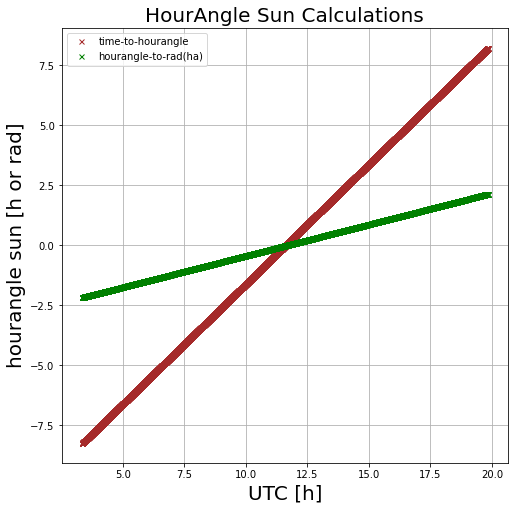

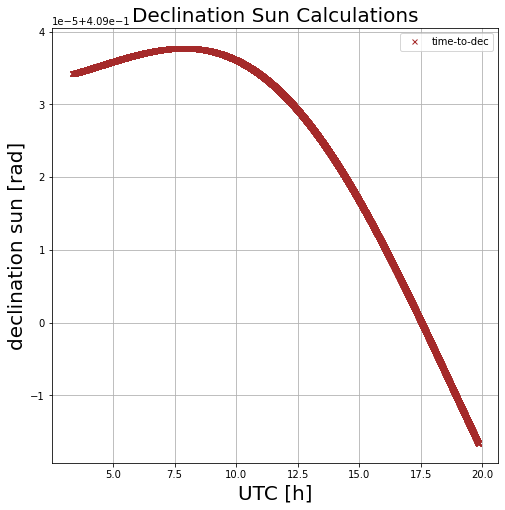

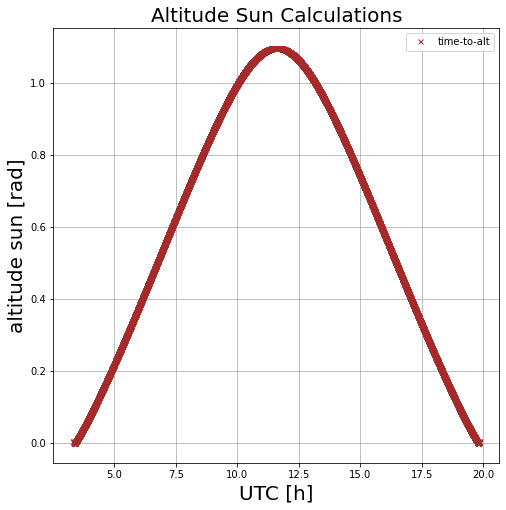

In [5]:
# plots of hourangle and declination of sun
plt.figure(figsize=(8,8))
plt.title("HourAngle Sun Calculations", fontsize=20)
plt.plot(time_sun, ha,color="brown",marker="x", markersize=5,ls='None',label="time-to-hourangle")
plt.plot(time_sun, ha_rad,color="green",marker="x", markersize=5,ls='None',label="hourangle-to-rad(ha)")
plt.grid()
plt.legend(loc="best", prop={'size': 10})
plt.xlabel('UTC [h]',fontsize=20)
plt.ylabel('hourangle sun [h or rad]',fontsize=20)

plt.figure(figsize=(8,8))
plt.title("Declination Sun Calculations", fontsize=20)
plt.plot(time_sun, dec,color="brown",marker="x", markersize=5,ls='None',label="time-to-dec")
plt.grid()
plt.legend(loc="best", prop={'size': 10})
plt.xlabel('UTC [h]',fontsize=20)
plt.ylabel('declination sun [rad]',fontsize=20)

plt.figure(figsize=(8,8))
plt.title("Altitude Sun Calculations", fontsize=20)
plt.plot(time_sun, alt,color="brown",marker="x", markersize=5,ls='None',label="time-to-alt")
plt.grid()
plt.legend(loc="best", prop={'size': 10})
plt.xlabel('UTC [h]',fontsize=20)
plt.ylabel('altitude sun [rad]',fontsize=20)


min scale from uv coverage: 2.2478221313219726 deg
time of min scale: 10.001989337822671
max scale from uv coverage: 6.753194642251442 deg
time of max scale: 17.585208770877088
min scale from uv coverage: 0.7999138223220147 deg
time of min scale: 5.076193758264716
max scale from uv coverage: 2.0112329248423104 deg
time of max scale: 11.07682826615995
min scale from uv coverage: 6.052446387552351 deg
time of min scale: 11.584574262981853
max scale from uv coverage: 15.21894344643916 deg
time of max scale: 17.585208770877088


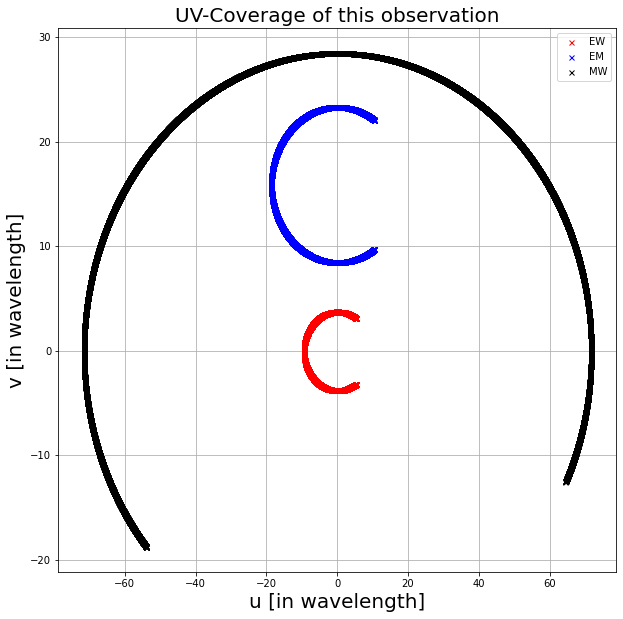

In [7]:
# According to baseline vector, calculate baseline length
D_em = baseline_length('EM',B_x=2,B_y=0,B_z=5)
D_mw = baseline_length('MW',B_x=2,B_y=15,B_z=0)
D_ew = baseline_length('EW',B_x=2,B_y=0.0,B_z=0.0)
#print(D_em)
# calculate and plot u,v and w coordinates in units of wavelength
uvw_em =uvw(time_sun,wavel,ha_rad,dec,alpha=D_em[1], d=D_em[2],D=D_em[0])
uvw_mw =uvw(time_sun,wavel,ha_rad,dec,alpha=D_mw[1], d=D_mw[2],D=D_mw[0])
uvw_ew =uvw(time_sun,wavel,ha_rad,dec,alpha=D_ew[1], d=D_ew[2],D=D_ew[0])

# plot uv coverage
plt.figure(figsize=(10,10))
plt.title("UV-Coverage of this observation", fontsize=20)
plt.plot(uvw_ew[0], uvw_ew[1],color="red",marker="x", markersize=5,ls='None',label="EW")
plt.plot(uvw_em[0], uvw_em[1],color="blue",marker="x", markersize=5,ls='None',label="EM")
plt.plot(uvw_mw[0], uvw_mw[1],color="black",marker="x", markersize=5,ls='None',label="MW")
plt.grid()
#plt.xlim(-50,50)
#plt.ylim(-50,50)
plt.legend(loc="best", prop={'size': 10})
plt.xlabel('u [in wavelength]',fontsize=20)
plt.ylabel('v [in wavelength]',fontsize=20)
plt.savefig('uv_coverage_simulation.png',dpi=500,bbox_inches='tight')
    